# Running combat on IDPs

In [32]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

import glob, re, os

from neuroCombat import neuroCombat
import covbat as cb
import patsy

sns.set_theme()
sns.set_context("talk")

In [33]:
# some useful dictonaries and lists
vendor_dict = {"TRI": "Siemens", "PRI": "Siemens", "ING": "Philips", "ACH": "Philips", "GEM": "GE"}

scanner_dict = {"NOT1ACH": "Philips Achieva",
                "NOT2ING": "Philips Ingenia", 
                "NOT3GEM": "GE MR750", 
                "OXF1PRI": "Siemens Prisma 32",
                "OXF2PRI": "Siemens Prisma 64",
                "OXF3TRI": "Siemens Trio"}

scanner_code_dict = {"NOT1ACH": "Ach",
                        "NOT2ING": "Ing", 
                        "NOT3GEM": "750", 
                        "OXF1PRI": "Pri32",
                        "OXF2PRI": "Pri64",
                        "OXF3TRI": "Trio"}

fmriopt_dict = {"task-rest_acq-multiband4_bold": "Ing: MB4", # we want to keep the MB4 data
                "task-rest_acq-multiband6_bold": "Ing: MB6", 
                "task-rest_acq-resopt1_bold": "GE: 2.4iso",
                "task-rest_acq-resopt2_bold": "GE: 3.3iso", # we want to keep the 3.3mm data
                "task-rest_acq-resopt3_bold": "GE: 2.2x2.3x3.3"}

fmriopt_key_dict = {"task-rest_bold": "standard",
                    "task-rest_acq-multiband4_bold": "standard",
                    "task-rest_acq-multiband6_bold": "non-standard", 
                    "task-rest_acq-resopt1_bold": "non-standard",
                    "task-rest_acq-resopt2_bold": "standard", 
                    "task-rest_acq-resopt3_bold": "non-standard"} # standard are used for analyses

# the session info headers
fmri_info_hdrs = ['fmriopt_key', 'fmriopt', 'fmri_modality', 'fmri_spacing_tr', 
                   'fmri_spacing_x', 'fmri_spacing_y', 'fmri_spacing_z', 'fmri_size_t', 'fmri_scan_time']

basic_info_hdrs = ['session', 'scanner_name', 'vendor', 'scanner_code', 
#                    'denoised',
             'scanner_type', 'scanner_typeloc', 'scan_session_num', 'scan_session', 'subject']

info_hdrs = basic_info_hdrs + fmri_info_hdrs

##### IQM headers
# the T1w IQMs
anat_iqm_hdrs = ['T1w_fwhm_avg', 'T1w_fwhm_x', 'T1w_fwhm_y', 'T1w_fwhm_z', 
               'T1w_snr_total', 'T1w_snr_gm', 'T1w_snr_wm', 'T1w_snr_csf', 
               'T1w_snrd_total', 'T1w_snrd_gm', 'T1w_snrd_wm', 'T1w_snrd_csf', 
#                'T1w_effective_snr_total', 'T1w_effective_snr_gm', 'T1w_effective_snr_wm', 'T1w_effective_snr_csf', 
#                'T1w_effective_snrd_total', 'T1w_effective_snrd_gm', 'T1w_effective_snrd_wm', 'T1w_effective_snrd_csf', 
               'T1w_qi_1', 'T1w_cnr', 'T1w_cjv', 'T1w_efc']

# the fMRI IQMs (first 3 are UKBB measures)
fmri_iqm_hdrs = ['rfMRI_head_motion', 'rfMRI_TSNR', 'rfMRI_cleaned_TSNR', 'fmri_fwhm_avg',
                'fmri_fwhm_x', 'fmri_fwhm_y', 'fmri_fwhm_z', 
#                  'fmri_snr', 'fmri_tsnr', 
                 'fmri_effective_snr', 'fmri_effective_tsnr', 'fmri_etSNR/Pri',
                 'fmri_efc', 'fmri_fd_mean', 'fmri_fd_perc', 'fmri_aor', 'fmri_aqi']# , 'fmri_fber']

# the dMRI IQMs - excluding the higher shell QC measures (as GE is single-shell)
dmri_iqm_hdrs = ['dMRI_eddy_outlier', 'dMRI_qc_cnr_avg_1', 'dMRI_qc_cnr_avg_2',
       'dMRI_qc_cnr_std_1', 'dMRI_qc_cnr_std_2',
       'dMRI_qc_outliers_b_1',
       'dMRI_qc_outliers_pe_1', 'dMRI_qc_mot_abs', 'dMRI_qc_mot_rel',
       'dMRI_qc_outliers_tot']

all_dmri_iqm_hdrs = ['dMRI_eddy_outlier', 'dMRI_qc_cnr_avg_1', 'dMRI_qc_cnr_avg_2',
       'dMRI_qc_cnr_avg_3', 'dMRI_qc_cnr_std_1', 'dMRI_qc_cnr_std_2',
       'dMRI_qc_cnr_std_3', 'dMRI_qc_outliers_b_1', 'dMRI_qc_outliers_b_2',
       'dMRI_qc_outliers_pe_1', 'dMRI_qc_mot_abs', 'dMRI_qc_mot_rel',
       'dMRI_qc_outliers_tot']

# all IQM headers
iqm_hdrs = anat_iqm_hdrs + fmri_iqm_hdrs + dmri_iqm_hdrs



In [34]:
def get_measure_type(measure_names, IDP=True):
    measure_type = []
    if IDP == True:
        for l in measure_names:
            if 'dMRI_TBSS' in l:
                measure_type = measure_type + [re.search('dMRI_(.*)_[0-9]+', l).group(1).replace('TBSS', 'dMRI ROI')]
            elif 'dMRI_xtract' in l:
                measure_type = measure_type + [re.search('dMRI_(.*)_[0-9]+', l).group(1).replace('xtract', 'dMRI tract')]
            elif 'T1_SIENAX' in l:
                measure_type = measure_type + ['FSL Tissue volumes']
            elif 'T1_GM_parcellation' in l:
                measure_type = measure_type + ['FSL GM volumes']
            elif 'T1_FIRST' in l:
                measure_type = measure_type + ['FSL Subcortical volumes']
            elif 'SWI_T2star' in l:
                measure_type = measure_type + ['SWI T2* subcortex']  
            elif 'freesurfer' in l:
                if 'aseg' in l:
                    measure_type = measure_type + ['FreeSurfer Subcortical volumes']
                elif 'DK' in l:
                    if 'SurfArea' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical surface area (DK)']
                    elif 'GrayVol' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical volume (DK)'] 
                    elif 'ThickAvg' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical thickness (DK)']
                    elif 'MeanCurv' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical curvature (DK)']
                elif 'a2009s' in l:
                    if 'SurfArea' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical surface area (Destrieux)']
                    elif 'GrayVol' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical volume (Destrieux)'] 
                    elif 'ThickAvg' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical thickness (Destrieux)']
                    elif 'MeanCurv' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical curvature (Destrieux)']
            elif 'fastsurfer' in l:
                if 'aseg' in l:
                    measure_type = measure_type + ['FastSurfer Subcortical volumes']
                elif 'DK' in l:
                    if 'SurfArea' in l:
                        measure_type = measure_type + ['FastSurfer Cortical surface area (DK)']
                    elif 'GrayVol' in l:
                        measure_type = measure_type + ['FastSurfer Cortical volume (DK)'] 
                    elif 'ThickAvg' in l:
                        measure_type = measure_type + ['FastSurfer Cortical thickness (DK)']
                    elif 'MeanCurv' in l:
                        measure_type = measure_type + ['FastSurfer Cortical curvature (DK)']
                
    measure_type = [l.replace('_', ' ') for l in measure_type]
    measure_type = [l.replace('v1', ' ') for l in measure_type]
    return measure_type

def get_stats(df):
    mn = df.mean(axis=0).abs()
    std = df.std(axis=0).abs()
    med = df.median(axis=0).abs()
    mad = (df - df.mean(axis=0)).abs().mean()
    mad_med = mad/med
    cv = std/mn
    return mn, med, mad, cv, mad_med

## Build main dataframe

#### Load UKBB pipeline data

In [35]:
studydir = '/Users/shaunwarrington/OneDrive - The University of Nottingham (1)/Deliverables/Papers/NHarmony'
fig_out = f'{studydir}/pyfigs'

# Load IDP headers
hdrs = np.loadtxt(f'{studydir}/data/headers.txt', 'str')
hdrs = np.concatenate([['session'], hdrs])
hdrs = [x for x in hdrs if 'mist' not in x] # not using MIST

# Load subject-wise IDPs
idp_files = glob.glob(f'{studydir}/data/IDPs/*[!denoise].txt')
df = [pd.read_csv(f, sep=" ", index_col=None, header=None) for f in idp_files]
df = pd.concat(df, ignore_index=True)

df.columns = hdrs
df = df[df.columns.drop(list(df.filter(regex='tfMRI')))] # drop task-fMRI IDPs

print(f'{df.shape[0]} sessions')
print('The raw measures:')
df.head(5)

99 sessions
The raw measures:


,session,1_l_align_to_std_diff,1_nl_align_to_std_diff,1_nl_align_to_std_warp,1_inverse_SNR,1_inverse_CNR,2_FLAIR_align_to_T1,MRI_align_to_T1,WI_align_to_T1,fMRI_align_to_T1,...,T1_GM_parcellation_L_VIIIb_Cerebellum_vol,T1_GM_parcellation_Vermis_VIIIb_Cerebellum_vol,T1_GM_parcellation_R_VIIIb_Cerebellum_vol,T1_GM_parcellation_L_IX_Cerebellum_vol,T1_GM_parcellation_Vermis_IX_Cerebellum_vol,T1_GM_parcellation_R_IX_Cerebellum_vol,T1_GM_parcellation_L_X_Cerebellum_vol,T1_GM_parcellation_Vermis_X_Cerebellum_vol,T1_GM_parcellation_R_X_Cerebellum_vol,T2_FLAIR_WMH_volume
0,03997_NOT2ING001,0.709639,0.565298,0.068010,0.023000,0.048365,0.417115,0.817849,0.398544,0.896350,...,2109.992313,329.589582,2049.580686,1162.600140,208.419435,1462.600181,578.780475,222.489944,442.430170,1293
1,14229_NOT2ING001,0.709498,0.558609,0.074845,0.023515,0.050278,0.332084,0.655481,0.396900,0.954145,...,2143.709358,353.850084,2574.299187,1158.141840,299.850408,1511.128623,575.468728,228.350319,631.039500,2118
2,10975_OXF1PRI001,0.671640,0.532363,0.060674,0.014329,0.029774,0.506442,0.606848,0.408396,0.862284,...,2109.548870,282.620293,2201.957280,1493.439980,277.000116,1541.828000,463.729077,230.000078,399.809908,89
3,13192_OXF2PRI001,0.751898,0.578664,0.066386,0.014678,0.031013,0.467204,0.739697,0.509247,0.966793,...,2340.322330,324.540300,1955.638035,1420.989965,309.450327,1752.868617,464.880968,175.439902,432.559840,594
4,03286_OXF2PRI001,0.779914,0.612624,0.075811,0.015209,0.034127,0.489486,0.624702,0.491941,0.867948,...,2426.239281,318.269952,2279.822940,1753.326639,419.030611,1997.429920,563.281340,239.979695,533.270100,4638


#### Get the header descriptions

In [36]:
hdr_descriptions = pd.read_csv(f'{studydir}/data/hdr_descriptions.txt', sep="\r\t", names=['desc'])
hdr_descriptions["hdr"] = np.loadtxt(f'{studydir}/data/headers.txt', 'str')
                                     
hdr_descriptions = hdr_descriptions[hdr_descriptions["hdr"].str.contains("tfMRI")==False]
hdr_descriptions = hdr_descriptions[hdr_descriptions["hdr"].str.contains("mist")==False]

def hdr_desc(hdr):
    try:
        desc = hdr_descriptions.loc[hdr_descriptions.hdr == hdr, 'desc'].values[0]
    except:
        desc = hdr
    return desc


/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38921/1054213702.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  hdr_descriptions = pd.read_csv(f'{studydir}/data/hdr_descriptions.txt', sep="\r\t", names=['desc'])


In [37]:
###### anat (T1 and T2) IQMs
df_anat = pd.read_csv(f'{studydir}/data/mriqc_anat_IQMs', sep=" ", index_col=None)

# separate T1w and T2w
df_t1 = df_anat[df_anat.modality == 'T1w']
df_t1 = df_t1.drop('modality', axis=1)
df_t1 = df_t1.add_prefix('T1w_')
df_t1.rename(columns={"T1w_session": "session"}, inplace=True)

df_t2 = df_anat[df_anat.modality == 'T2w']
df_t2 = df_t2.drop('modality', axis=1)
df_t2 = df_t2.add_prefix('T2w_')
df_t2.rename(columns={"T2w_session": "session"}, inplace=True)


#### Load FreeSurfer IDPs - aseg lh.aparc.DKTatlas rh.aparc.DKTatlas lh.aparc.a2009s rh.aparc.a2009s

In [38]:
###### aseg
measure_name = 'aseg'
idp_files = glob.glob(f'{studydir}/data/freesurfer_stats/{measure_name}/*')
tempdf = pd.DataFrame()
for f in idp_files:
    d = pd.read_csv(f, sep="\s+", index_col=None)
    d['session'] = os.path.basename(f)
    tempdf = pd.concat((tempdf, d), ignore_index=True)
    
# get volumes
val_cols = ['Volume_mm3']
tempdf = tempdf[['StructName', 'session'] + val_cols]
tempdf = tempdf.pivot(index='session', columns='StructName', values=val_cols)
tempdf.columns = ['_'.join(col).strip() for col in tempdf.columns.values]
tempdf.reset_index(inplace=True, drop=False)

# drop WM measures
tempdf = tempdf[tempdf.columns.drop(list(tempdf.filter(regex='WM-')))]

# add prefix
tempdf = tempdf.add_prefix(f'freesurfer_{measure_name}_')
tempdf.rename(columns={f'freesurfer_{measure_name}_session': 'session'}, inplace=True)

# build FreeSurfer dataframe
df_fs = tempdf.copy()

###### aparc cortical atlases
for measure_name in ['lh.aparc.DKTatlas', 'rh.aparc.DKTatlas', 'lh.aparc.a2009s', 'rh.aparc.a2009s']:
    idp_files = glob.glob(f'{studydir}/data/freesurfer_stats/{measure_name}/*')
    tempdf = pd.DataFrame()
    for f in idp_files:
        d = pd.read_csv(f, sep="\s+", index_col=None)
        d['session'] = os.path.basename(f)
        tempdf = pd.concat((tempdf, d), ignore_index=True)
    # get StructName, SurfArea, GrayVol, ThickAvg, MeanCurv
    val_cols = ['SurfArea', 'GrayVol', 'ThickAvg', 'MeanCurv']
    tempdf = tempdf[['StructName', 'session'] + val_cols]
    tempdf = tempdf.pivot(index='session', columns='StructName', values=val_cols)
    tempdf.columns = ['_'.join(col).strip() for col in tempdf.columns.values]
    tempdf.reset_index(inplace=True, drop=False)
    # add prefix
    tempdf = tempdf.add_prefix(f'freesurfer_{measure_name}_')
    tempdf.rename(columns={f'freesurfer_{measure_name}_session': 'session'}, inplace=True)
    df_fs = pd.merge(df_fs, tempdf, on="session")

# for aseg, only keep subcortical
# for h in ['Vent', 'CSF', 'CC', 'choroid-plexus', 'vessel', 'Optic-Chiasm', 'Cerebellum']:
#     df_fs = df_fs[df_fs.columns.drop(list(df_fs.filter(regex=h)))]


#### Merge the IQMs and FreeSurfer IDPs

In [39]:
# the IQM/QC dataframe
df = pd.merge(df, df_t1, on="session", how="left")

# merge the FreeSurfer IDPs
df = pd.merge(df, df_fs, on="session", how="left")


#### Drop unwanted IDPs

In [40]:
# T2 WM hyperintensities
df.drop(labels='T2_FLAIR_WMH_volume', axis=1, inplace=True)


#### Add session info columns

In [41]:
sublist = [t.split('_')[0] for t in df.session.values]
scan_session = [t.split('_')[1] for t in df.session.values]
scan_session_num = [t[-3:] for t in scan_session]
scanner_typeloc = [t.split('00')[0] for t in scan_session]
scanner_type = [t[-3:] for t in scanner_typeloc]

df.insert(1, 'subject', sublist)
df.insert(1, 'scan_session', scan_session)
df.insert(1, 'scan_session_num', scan_session_num)
df.insert(1, 'scanner_typeloc', scanner_typeloc)
df.insert(1, 'scanner_type', scanner_type)
df.insert(1, 'vendor', df['scanner_type'].map(vendor_dict))
df.insert(1, 'scanner_name', df['scanner_typeloc'].map(scanner_dict))
df.insert(1, 'scanner_code', df['scanner_typeloc'].map(scanner_code_dict))

df.sort_values('session', inplace=True, ignore_index=True)
df.columns = df.columns.str.strip()

#### separate subjects with fmriopts

In [42]:
## For GE (resolution options)
# subject 03286 has 2 fmri data: 2.4iso and 2.2x2.2x3.3
# all other subjects have 2.4iso and 3.3iso
# we want to keep 3.3iso - this is sessions 001 for all expcept 03286

## For Ingenia (multiband/TR options)
# subject 14482 is missing the MB6 option
# we want to keep MB 4 - this is sessions 001

# these are all occruances of ING002 and GEM002
df_fmriopts = df.loc[(df['scan_session_num'] == '002') & 
                     (df['scanner_type'].isin(['GEM', 'ING']))]
df_fmriopts_idx = df_fmriopts.index.values # indices to remove from main df
df.drop(index=(df_fmriopts_idx), inplace=True) # remove from main df

# get alternative fMRI version data
grab = [s.replace('002', '001') for s in df_fmriopts.session.values]
df_fmriopts = pd.concat((df_fmriopts, df[df.session.isin(grab)]))
df_fmriopts.sort_values('session', inplace=True, ignore_index=True)

print(f'{df_fmriopts.shape[0]} sessions')
print('The fMRI-opt measures:')
df_fmriopts.head(5)

38 sessions
The fMRI-opt measures:


,session,scanner_code,scanner_name,vendor,scanner_type,scanner_typeloc,scan_session_num,scan_session,subject,1_l_align_to_std_diff,...,freesurfer_rh.aparc.a2009s_MeanCurv_S_parieto_occipital,freesurfer_rh.aparc.a2009s_MeanCurv_S_pericallosal,freesurfer_rh.aparc.a2009s_MeanCurv_S_postcentral,freesurfer_rh.aparc.a2009s_MeanCurv_S_precentral-inf-part,freesurfer_rh.aparc.a2009s_MeanCurv_S_precentral-sup-part,freesurfer_rh.aparc.a2009s_MeanCurv_S_suborbital,freesurfer_rh.aparc.a2009s_MeanCurv_S_subparietal,freesurfer_rh.aparc.a2009s_MeanCurv_S_temporal_inf,freesurfer_rh.aparc.a2009s_MeanCurv_S_temporal_sup,freesurfer_rh.aparc.a2009s_MeanCurv_S_temporal_transverse
0,03286_NOT2ING001,Ing,Philips Ingenia,Philips,ING,NOT2ING,001,NOT2ING001,03286,0.674815,...,0.104,0.114,0.085,0.089,0.079,0.118,0.098,0.107,0.098,0.142
1,03286_NOT2ING002,Ing,Philips Ingenia,Philips,ING,NOT2ING,002,NOT2ING002,03286,0.674815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,03286_NOT3GEM001,750,GE MR750,GE,GEM,NOT3GEM,001,NOT3GEM001,03286,0.739996,...,0.102,0.111,0.090,0.093,0.084,0.113,0.099,0.104,0.100,0.143
3,03286_NOT3GEM002,750,GE MR750,GE,GEM,NOT3GEM,002,NOT3GEM002,03286,0.739996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,03997_NOT2ING001,Ing,Philips Ingenia,Philips,ING,NOT2ING,001,NOT2ING001,03997,0.709639,...,0.125,0.144,0.111,0.092,0.095,0.119,0.145,0.111,0.103,0.081


#### Manual fix of 14230_NOT1ACH001 GM volumes

In [43]:
# after T1_GM_parcellation_Vermis_Crus_I_Cerebellum_vol in 14230_NOT1ACH001, values are incorrect
# T1_GM_parcellation_Vermis_Crus_I_Cerebellum_vol is missing and returns "missing label:" rather than values
# this throws off the awk, which feeds to multiplication with bc, and therefore performs the wrong calculation

# manually fix this 
idp_hdrs = list(df.filter(regex='T1_').columns.values)
ind = idp_hdrs.index('T1_GM_parcellation_Vermis_Crus_I_Cerebellum_vol')
hdrs_replace = idp_hdrs[ind:]

newvals = np.array([[0, 0],
                   [0.575510, 18538],
                   [0.531252, 14219],
                   [0.660524, 458],
                   [0.510263, 13543],
                   [0.576694, 6663],
                   [0.740000, 156],
                   [0.511343, 5936],
                   [0.483337, 7452],
                   [0.490643, 1306],
                   [0.481907, 6486],
                   [0.436989, 5954],
                   [0.536384, 614],
                   [0.397254, 7366],
                   [0.388458, 4215],
                   [0.315826, 860],
                   [0.381237, 5709],
                   [0.260741, 1647],
                   [0.423785, 362],
                   [0.240589, 1766]])
newvals = newvals[:,0]*newvals[:,1]

df.loc[df.session == '14230_NOT1ACH001', hdrs_replace] = newvals

#### Useful main data (df) lists

In [44]:
df.sort_values('session', inplace=True, ignore_index=True)

# subject, vendor and scanner lists
sub_list = df.subject.unique()
ven_list = df.vendor.unique()
scanner_typeloc_list = df.scanner_typeloc.unique()
scanner_type_list = df.scanner_type.unique()

reptlist = [["13192", "OXF1PRI"],
            ["14229", "OXF2PRI"],
            ["14230", "OXF3TRI"],
            ["14482", "NOT1ACH"]]

print(f'{len(sub_list)} subjects')
print(f'{len(ven_list)} vendors')
print(f'{len(scanner_typeloc_list)} scanners')
print(f'{len(scanner_type_list)} scanner types')


10 subjects
3 vendors
6 scanners
5 scanner types


In [45]:
def prep_df(df, idp_hdrs):
    df = df[['session'] + idp_hdrs]# get the subset of wanted IDPs
    df.set_index('session', inplace=True)# first set session ID as index
    df = df.transpose()# transpose so subjects are columns
    # find any NaN rows and drop
    nan_inds = df.index[df.isna().any(axis=1)]
    if len(nan_inds) > 0:
        print(f'Found {len(nan_inds)} NaN rows. Removing:')
        for i in nan_inds: print(i)
    df = df.drop(nan_inds)
    idp_hdrs = [i for i in idp_hdrs if i not in nan_inds]
    
    return df, idp_hdrs

def add_info(df):
    sublist = [t.split('_')[0] for t in df.session.values]
    scan_session = [t.split('_')[1] for t in df.session.values]
    scan_session_num = [t[-3:] for t in scan_session]
    scanner_typeloc = [t.split('00')[0] for t in scan_session]
    scanner_type = [t[-3:] for t in scanner_typeloc]
    df.insert(1, 'subject', sublist)
    df.insert(1, 'scan_session', scan_session)
    df.insert(1, 'scan_session_num', scan_session_num)
    df.insert(1, 'scanner_typeloc', scanner_typeloc)
    df.insert(1, 'scanner_type', scanner_type)
    df.insert(1, 'vendor', df['scanner_type'].map(vendor_dict))
    df.insert(1, 'scanner_name', df['scanner_typeloc'].map(scanner_dict))
    df.insert(1, 'scanner_code', df['scanner_typeloc'].map(scanner_code_dict))
    return df

def get_cov(df, idp_hdrs):
    # get CoV for FIRST IDPs within and between scanners
    seg_cov = pd.DataFrame()
    # within-scanner CoV
    for sub, sca in zip(["13192", "14229", "14230", "14482"],["OXF1PRI", "OXF2PRI", "OXF3TRI", "NOT1ACH"]):
        mn, med, mad, cv, mad_med = get_stats(df[(df.subject == sub) & (df.scanner_typeloc == sca)][idp_hdrs])
        measure_type = get_measure_type(cv.index)
        tempdf = pd.DataFrame({"IDP": cv.index, "value": cv, 'subject': sub, 'scanners': 'within\nscanner'})
        seg_cov = pd.concat((seg_cov, tempdf))
    # between-scanner CoV
    for sub in ["13192", "14229", "14230", "14482"]:
        mn, med, mad, cv, mad_med = get_stats(df[(df.subject == sub) & (df.scan_session_num == '001')][idp_hdrs])
        measure_type = get_measure_type(cv.index)
        tempdf = pd.DataFrame({"IDP": cv.index, "value": cv, 'subject': sub, 'scanners': 'between\nscanner'})
        seg_cov = pd.concat((seg_cov, tempdf))
    # add a method column denoting whether FIRST or MIST
    seg_cov['Method'] = seg_cov['IDP']
    seg_cov.loc[seg_cov['Method'].str.contains('raw'), 'Method'] = 'Raw'
    seg_cov.loc[seg_cov['Method'].str.contains('combat-gam'), 'Method'] = 'ComBat-GAM'
    seg_cov.loc[seg_cov['Method'].str.contains('combat'), 'Method'] = 'ComBat'
    seg_cov.loc[seg_cov['Method'].str.contains('covbat'), 'Method'] = 'CovBat'
    return seg_cov

    
def get_rankingcorr(df, idp_hdrs, sublist):
    corrdf = []
    for j, h in enumerate(idp_hdrs):
        arr = np.zeros((len(sublist), len(scanner_typeloc_list)))
        for i, sca in enumerate(scanner_typeloc_list):
            arr[:, i] = df[(df.scan_session_num == '001') & (df.scanner_typeloc == sca)][h]

        corr = sc.stats.spearmanr(arr, axis=0, nan_policy='omit')[0]
        corr = corr[np.triu_indices_from(corr, k=1)]
        corrdf.append(np.mean(corr))
    corrdf = pd.DataFrame({'IDP':idp_hdrs, 'value':corrdf})
    measure_type = get_measure_type(corrdf.IDP)
    corrdf['IDP_type'] = measure_type
    corrdf['scanners'] = 'All scanners'

    # Siemens only
    corrdf_sie = []
    siemens_list = ['OXF1PRI', 'OXF2PRI', 'OXF3TRI']
    for j, h in enumerate(idp_hdrs):
        arr = np.zeros((len(sublist), len(siemens_list)))
        for i, sca in enumerate(siemens_list):
            arr[:, i] = df[(df.scan_session_num == '001') & (df.vendor == 'Siemens') & (df.scanner_typeloc == sca)][h]

        corr = sc.stats.spearmanr(arr, axis=0, nan_policy='omit')[0]
        corr = corr[np.triu_indices_from(corr, k=1)]

        corrdf_sie.append(np.mean(corr))

    corrdf_sie = pd.DataFrame({'IDP':idp_hdrs, 'value':corrdf_sie})
    measure_type = get_measure_type(corrdf_sie.IDP)
    corrdf_sie['IDP_type'] = measure_type
    corrdf_sie['scanners'] = 'Siemens only'

    # combine dataframes
    # IDP-category-wise box plots
    plotdf = pd.concat((corrdf, corrdf_sie))

    # add a method column denoting whether FIRST or MIST
    plotdf['Method'] = plotdf['IDP']
    plotdf.loc[plotdf['Method'].str.contains('raw'), 'Method'] = 'Raw'
    plotdf.loc[plotdf['Method'].str.contains('combat-gam'), 'Method'] = 'ComBat-GAM'
    plotdf.loc[plotdf['Method'].str.contains('combat'), 'Method'] = 'ComBat'
    plotdf.loc[plotdf['Method'].str.contains('covbat'), 'Method'] = 'CovBat'
    return plotdf


def get_null_corr(figobj, nsamp1=10, nsamp2=6, niter=1000):
    nullcorr = np.zeros((niter,))
    for i in range(0, niter):
        nullcorr[i] = sc.stats.spearmanr(np.random.choice(range(nsamp1), nsamp1, replace=False), 
                           np.random.choice(range(nsamp1), nsamp1, replace=False), axis=1)[0]
        
    null_iqr = np.percentile(nullcorr, [25, 75])
    
    if hasattr(figobj, 'get_xlim'):
        xlims = figobj.get_xlim()[0], figobj.get_xlim()[1]
        ylims = figobj.get_ylim()[0], figobj.get_ylim()[1]
        figobj.fill_between([xlims[0]-1, xlims[1]+1], null_iqr[0], null_iqr[1], color='red', alpha=0.2)
        figobj.set_xlim(xlims[0], xlims[1])
        figobj.set_ylim(0, ylims[1])
    else:
        ylims = figobj.axes[0][0].get_ylim()[0], figobj.axes[0][0].get_ylim()[1]
        
        for ax in figobj.axes[0]:
            xlims = ax.get_xlim()[0], ax.get_xlim()[1]
            ax.fill_between([xlims[0]-1, xlims[1]+1], null_iqr[0], null_iqr[1], color='red', alpha=0.2)
            ax.set_xlim(xlims[0], xlims[1])
            
        g.set(ylim=(ylims[0], ylims[1]))


## Harmonise FreeSurfer (DK)

In [46]:
# add subject demographics to main df
subject_demo = pd.DataFrame(columns=['subject', 'sex', 'age'], 
                            data=[['03286', 'M', 48],
                                  ['03997', 'M', 37],
                                  ['10975', 'M', 25],
                                  ['12813', 'F', 24],
                                  ['13192', 'M', 47],
                                  ['13305', 'M', 42],
                                  ['14221', 'M', 25],
                                  ['14229', 'M', 35],
                                  ['14230', 'F', 25],
                                  ['14482', 'M', 24]])

df['sex'] = [subject_demo[subject_demo.subject == i]['sex'].values[0] for i in df.subject]
df['sex'] = df['sex'].replace('M', 0)
df['sex'] = df['sex'].replace('F', 1)
df['age'] = [subject_demo[subject_demo.subject == i]['age'].values[0] for i in df.subject]


In [47]:
def harm_comp(df, idp_hdrs, sublist, covbat=False, plot_it=True, draw_null=True):
    # reduce to only the subjects of interest (those with repeats)
    df_fs = df[(df.subject.isin(sublist)) & (df.scan_session_num == '001')].copy()
    covars = pd.DataFrame({"batch": df_fs.scanner_typeloc.values, "age": df_fs.age, "sex": df_fs.sex}) # the batch ID vector
    df_fs, idp_hdrs = prep_df(df_fs, idp_hdrs) # the data matrix
    idp_hdrs = df_fs.index.values.tolist()
    
    # run ComBat
    data_combat = neuroCombat(dat=df_fs,
        covars=covars,
        batch_col="batch",
        categorical_cols="sex")["data"];

    data_combat = pd.DataFrame(data=data_combat, index=idp_hdrs, columns=covars.batch.values)
    data_combat.set_index('combat_' + data_combat.index.astype(str), inplace=True)
    df_fs.set_index('raw_' + df_fs.index.astype(str), inplace=True)
    data_combat = data_combat.transpose().reset_index(drop=True)
    data_combat['session'] = df_fs.columns.values
    
    # covbat?
    if covbat == True:
        temp = df[(df.subject.isin(sublist)) & (df.scan_session_num == '001')].copy()
        covars = pd.DataFrame({"batch": temp.scanner_typeloc.values, "age": temp.age, "sex": temp.sex}) # the batch ID vector
        temp, idp_hdrs = prep_df(temp, idp_hdrs) # the data matrix
        covars.index = temp.columns.values
        mod = patsy.dmatrix("~ age + sex", covars, return_type="dataframe")
        cov_dat = cb.covbat(temp, covars.batch, model=mod, numerical_covariates=['age'])

    
    # Merge with raw IDPs
    # ComBat
    df_fs = pd.merge(df_fs.transpose().reset_index(), data_combat, on="session", how="left")
    
    # covbat
    if covbat == True:
        cov_dat = cov_dat.transpose()
        cov_dat = cov_dat.add_prefix('covbat_')
        cov_dat.reset_index(inplace=True)
        df_fs = pd.merge(df_fs, cov_dat, on="session", how="left")

    # re-add in the within-scanner FreeSurfer (no ComBat) measures
    tempdf = df[(df.subject.isin(sublist)) & (df.scan_session_num != '001')][["session"] + idp_hdrs]
    tempdf = tempdf.add_prefix('raw_')
    tempdf.rename(columns={'raw_session': 'session'}, inplace=True)
    df_fs = pd.concat((df_fs, tempdf))
    df_fs = add_info(df_fs)
    
    idp_hdrs = ["raw_" + h for h in idp_hdrs]
    idp_hdrs = idp_hdrs + [h.replace('raw', 'combat') for h in idp_hdrs if 'raw' in h]
    if cgam == True:
        idp_hdrs = idp_hdrs + [h.replace('raw', 'combat-gam') for h in idp_hdrs if 'raw' in h]
    if covbat == True:
        idp_hdrs = idp_hdrs + [h.replace('raw', 'covbat') for h in idp_hdrs if 'raw' in h]

    # get CoV
    seg_cov = get_cov(df_fs, idp_hdrs)
    seg_cov = seg_cov[seg_cov['value'].notna()] # drop the "between scanner harmonised" values
    
    # re-name
    conditions = [
        seg_cov['Method'].eq('Raw') & seg_cov['scanners'].eq('within\nscanner'),
        seg_cov['Method'].eq('Raw') & seg_cov['scanners'].eq('between\nscanner'),
        seg_cov['Method'].eq('ComBat') & seg_cov['scanners'].eq('between\nscanner'),
        seg_cov['Method'].eq('CovBat') & seg_cov['scanners'].eq('between\nscanner'),

    choices = ['within\nscanner', 'between\nscanner', 'ComBat', 'CovBat']
    seg_cov['Method'] = np.select(conditions, choices, default=0)

    # get correlation of ranking
    cor = get_rankingcorr(df_fs, idp_hdrs, sublist)
    
    if plot_it == True: 
        sns.set(font_scale = 1.5)
        fig, axes = plt.subplots(2, 1, figsize=(9, 10))

        # CoV
        g = sns.boxplot(data=seg_cov, x='Method', y='value', 
                        boxprops={'alpha': 0.4}, palette="deep", ax=axes[0])
        sns.stripplot(data=seg_cov, x='Method', y='value', 
                      dodge=True, s=3, ax=axes[0])
        axes[0].set_ylabel('Coefficient of Variation');
        axes[0].set_xlabel('');
        
        # CoR
        g = sns.boxplot(data=cor, x='Method', y='value', hue='scanners', 
                        boxprops={'alpha': 0.4}, ax=axes[1])
        sns.stripplot(data=cor, x='Method', y='value', hue='scanners', 
                      dodge=True, s=3, ax=axes[1])
        
        axes[1].set_ylabel('Correlation of Ranking');
        axes[1].set_xlabel('');
        handles, labels = axes[1].get_legend_handles_labels()
        axes[1].legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
                        labels=['All scanners', 'Siemens only'],
                        handler_map={tuple: matplotlib.legend_handler.HandlerTuple(ndivide=None)},
                        loc='lower right', fontsize=14, frameon=False, handlelength=4
                      )
        axes[1].set_ylim(0.65, axes[1].get_ylim()[1])
        g.set(xlabel='', ylabel='Correlation of Ranking')
    return df_fs, idp_hdrs, seg_cov, cor


In [48]:
idp_hdrs = list(df.filter(regex='T1_GM').columns.values)
hdr_rm = ['Thalamus', 'Caudate', 'Putamen', 'Pallidum', 'Hippocampus', 
         'Amygdala', 'Vent_Striatum', 'Brain-Stem', 'Cerebellum']

for st in hdr_rm:
    idp_hdrs = [x for x in idp_hdrs if st not in x]

    
df_fs = df[(df.subject.isin(sublist)) & (df.scan_session_num == '001')].copy()
covars = pd.DataFrame({"batch": df_fs.scanner_typeloc.values, "age": df_fs.age, "sex": df_fs.sex}) # the batch ID vector
df_fs, idp_hdrs = prep_df(df_fs, idp_hdrs) # the data matrix
idp_hdrs = df_fs.index.values.tolist()


covars.index = df_fs.columns.values
mod = patsy.dmatrix("~ age + sex", covars, return_type="dataframe")
covbat = cb.covbat(df_fs, covars.batch, model=mod, numerical_covariates=['age'])
covbat = covbat.transpose()
covbat.reset_index(inplace=True)
covbat

Adjusting data


/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:92: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 1 numerical covariates...
	age
found 1 categorical variables:	sex
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:234: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding 

Adjusting data


,session,T1_GM_parcellation_L_Front_Pole_vol,T1_GM_parcellation_R_Front_Pole_vol,T1_GM_parcellation_L_Insula_vol,T1_GM_parcellation_R_Insula_vol,T1_GM_parcellation_L_Sup_Front_Gyr_vol,T1_GM_parcellation_R_Sup_Front_Gyr_vol,T1_GM_parcellation_L_Mid_Front_Gyr_vol,T1_GM_parcellation_R_Mid_Front_Gyr_vol,T1_GM_parcellation_L_Inf_Front_Gyr_pars_triangularis_vol,...,T1_GM_parcellation_L_Planum_Polare_vol,T1_GM_parcellation_R_Planum_Polare_vol,T1_GM_parcellation_L_Heschl_Gyr_vol,T1_GM_parcellation_R_Heschl_Gyr_vol,T1_GM_parcellation_L_Planum_Tempe_vol,T1_GM_parcellation_R_Planum_Tempe_vol,T1_GM_parcellation_L_Supracalcarine_vol,T1_GM_parcellation_R_Supracalcarine_vol,T1_GM_parcellation_L_Occ_Pole_vol,T1_GM_parcellation_R_Occ_Pole_vol
0,03286_NOT1ACH001,22986.756595,26350.996119,6576.637448,6689.989026,11199.577764,9872.939089,11159.747449,10105.851068,2511.760703,...,1511.744945,1287.672819,1146.248188,882.764353,2030.285370,1640.653684,492.635354,803.737571,8016.711207,7985.355325
1,03286_NOT2ING001,22542.646900,26075.066847,6704.379831,6772.325674,11244.131069,10008.481467,11670.946975,10106.177127,2500.191262,...,1511.156809,1334.501161,1156.563588,872.885562,2002.412873,1593.535960,500.194032,795.219899,7616.964483,8121.241296
2,03286_NOT3GEM001,23674.902095,27486.652001,6858.235310,6981.089878,12303.296253,11420.675753,11254.397105,10586.835031,2809.753455,...,1618.597425,1467.067124,1225.822880,947.195954,2170.513402,1638.733536,560.957728,700.721850,7902.938309,7570.714368
3,03286_OXF1PRI001,23326.563750,27027.195875,6624.360667,6670.557335,11697.010017,10217.053925,10106.274956,10099.716348,2655.281390,...,1558.257614,1440.279976,1131.474240,897.468779,1966.121054,1591.387204,480.910700,742.449116,7442.087863,7661.414876
4,03286_OXF2PRI001,23757.769268,26043.233216,6730.968759,6773.274491,11101.676805,9953.068018,10248.462933,10310.295968,2560.174652,...,1574.797024,1442.801409,1121.780575,883.183419,1930.888914,1603.963716,490.736319,801.848678,7064.173046,7885.255577
5,03286_OXF3TRI001,23139.589999,26702.235027,6602.670975,6610.477339,11426.902163,10252.746784,10322.704228,10199.601886,2665.308651,...,1536.892142,1394.401431,1137.948802,876.963224,1934.889807,1601.407053,470.908193,756.151770,7631.740461,7871.038453
6,03997_NOT1ACH001,27499.505563,31081.959702,6123.860810,5997.941152,13857.937126,12570.064971,13505.002476,10770.127916,2300.609554,...,1550.506705,1445.363780,1062.853765,1034.693182,1839.820976,1530.641990,519.898247,767.507519,7095.317844,8569.623922
7,03997_NOT2ING001,27715.692545,30225.703325,6279.556113,5910.073649,13741.710163,11996.989791,11982.027419,10145.472097,2319.320459,...,1550.551860,1467.577735,1091.788761,1047.392500,1793.746380,1497.428757,520.247440,851.288408,7089.234738,8564.562917
8,03997_NOT3GEM001,26760.569537,29816.648203,6055.043167,5979.251266,12471.027113,12545.272857,13741.632729,9241.468329,2269.216627,...,1482.621384,1363.962680,1050.197345,1119.187728,1673.794719,1430.664262,537.766942,919.379239,7064.415760,9386.446130
9,03997_OXF1PRI001,26680.251172,29258.382951,6298.905207,5954.665675,13292.162711,12419.210120,13337.778569,10955.501677,2259.265236,...,1604.086208,1462.073940,1116.477112,1113.352486,1864.217062,1671.232698,523.025104,772.313305,6991.749822,8834.581654


#### Atlas-based cortical volumes

In [50]:
idp_hdrs = list(df.filter(regex='T1_GM').columns.values)
hdr_rm = ['Thalamus', 'Caudate', 'Putamen', 'Pallidum', 'Hippocampus', 
         'Amygdala', 'Vent_Striatum', 'Brain-Stem', 'Cerebellum']

for st in hdr_rm:
    idp_hdrs = [x for x in idp_hdrs if st not in x]

df_ab, idp_hdrs, seg_cov_ab, cor_ab = harm_comp(df, idp_hdrs, sub_list, 
                                                covbat=True, plot_it=False)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Adjusting data


/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:92: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 1 numerical covariates...
	age
found 1 categorical variables:	sex
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:234: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding 

Adjusting data


#### Subcortical volumes

In [51]:
idp_hdrs = list(df.filter(regex='T1_FIRST').columns.values)
df_fs, idp_hdrs, seg_cov_sub, cor_sub = harm_comp(df, idp_hdrs, sub_list, 
                                                covbat=True, plot_it=False)


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Adjusting data
Adjusting data


/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:92: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 1 numerical covariates...
	age
found 1 categorical variables:	sex
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:234: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding 

#### T2* measures

In [52]:
idp_hdrs = list(df.filter(regex='SWI_T2star').columns.values)
df_fs, idp_hdrs, seg_cov_t2, cor_t2 = harm_comp(df, idp_hdrs, sub_list, 
                                                covbat=True, plot_it=False)


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Adjusting data
Adjusting data


/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:92: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 1 numerical covariates...
	age
found 1 categorical variables:	sex
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:234: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding 

#### Diffusion measures (FA and MD)

In [53]:
idp_hdrs = list(df.filter(regex='dMRI_TBSS_FA').columns.values)
df_fs, idp_hdrs, seg_cov_fa, cor_fa = harm_comp(df, idp_hdrs, sub_list, 
                                                covbat=True, plot_it=False)


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Adjusting data


/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:92: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 1 numerical covariates...
	age
found 1 categorical variables:	sex
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:234: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding 

Adjusting data


In [54]:
idp_hdrs = list(df.filter(regex='dMRI_TBSS_MD').columns.values)
df_fs, idp_hdrs, seg_cov_md, cor_md = harm_comp(df, idp_hdrs, sub_list, 
                                                covbat=True, plot_it=False)


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Adjusting data


/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:92: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 1 numerical covariates...
	age
found 1 categorical variables:	sex
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
/Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham(1)/Deliverables/Papers/NHarmony/scripts/covbat.py:234: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding 

Adjusting data


### Plot all other examples

/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38921/3402950212.py:50: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:
/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38921/3402950212.py:74: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


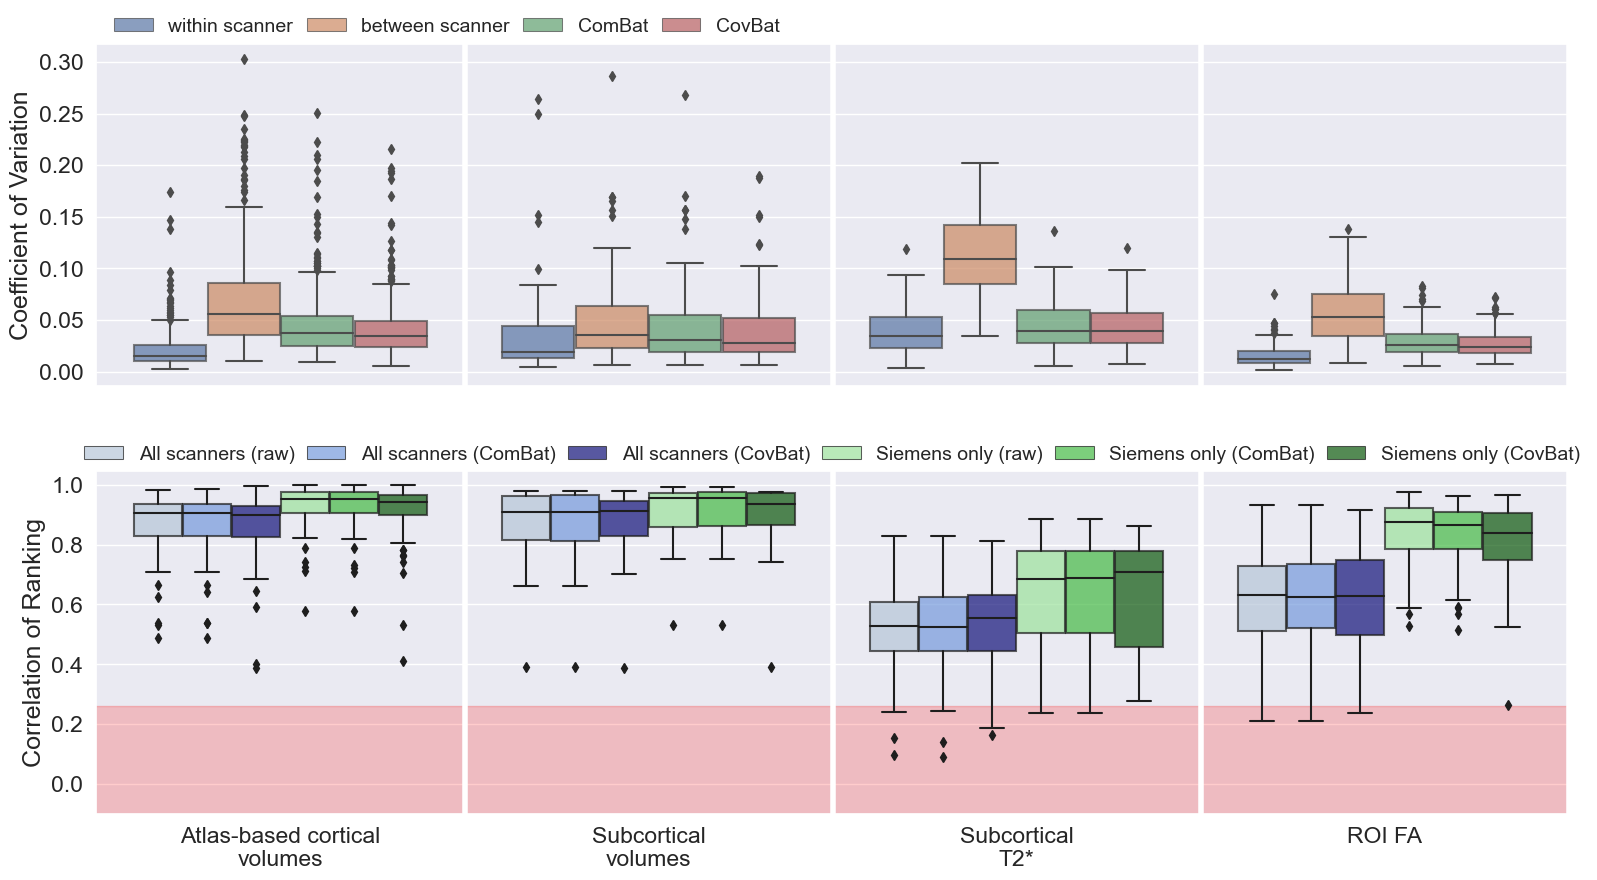

In [59]:
seg_cov_ab["IDP_type"] = 'Atlas-based cortical\nvolumes'
seg_cov_sub["IDP_type"] = 'Subcortical\nvolumes'
seg_cov_t2["IDP_type"] = 'Subcortical\nT2*'
seg_cov_fa["IDP_type"] = 'ROI FA'
seg_cov = pd.concat((seg_cov_ab, seg_cov_sub, seg_cov_t2, seg_cov_fa))
seg_cov.replace('\nscanner', ' scanner', regex=True, inplace=True)

cor_ab["IDP_type"] = 'Atlas-based cortical\nvolumes'
cor_sub["IDP_type"] = 'Subcortical\nvolumes'
cor_t2["IDP_type"] = 'Subcortical\nT2*'
cor_fa["IDP_type"] = 'ROI FA'
cor = pd.concat((cor_ab, cor_sub, cor_t2, cor_fa))

# re-name
conditions = [
    cor['Method'].eq('Raw') & cor['scanners'].eq('All scanners'),
    cor['Method'].eq('Raw') & cor['scanners'].eq('Siemens only'),
    cor['Method'].eq('ComBat') & cor['scanners'].eq('All scanners'),
    cor['Method'].eq('ComBat') & cor['scanners'].eq('Siemens only'),
    cor['Method'].eq('CovBat') & cor['scanners'].eq('All scanners'),
    cor['Method'].eq('CovBat') & cor['scanners'].eq('Siemens only')]

choices = ['All scanners (raw)', 'Siemens only (raw)',
           'All scanners (ComBat)', 'Siemens only (ComBat)',
           'All scanners (CovBat)', 'Siemens only (CovBat)']
cor['Method'] = np.select(conditions, choices, default=0)

sns.set(font_scale = 1.5)
fig, axes = plt.subplots(2, 1, figsize=(19, 10), sharex=True)

# CoV
g = sns.boxplot(data=seg_cov, x='IDP_type', y='value', hue="Method",
                boxprops={'alpha': 0.7}, width=0.8, palette="deep", ax=axes[0])
[axes[0].axvline(x+.5, color='w', lw=4) for x in axes[0].get_xticks()]
axes[0].set_ylabel('Coefficient of Variation');
axes[0].set_xlabel('');

leg = axes[0].legend(loc='center left', fontsize=14, frameon=False, 
                     bbox_to_anchor=(0, 1.05), ncol=4, columnspacing=0.7);
for lh in leg.legendHandles: 
    lh.set_alpha(0.7)

# CoR
p = {'All scanners (raw)': 'lightsteelblue',
     'All scanners (ComBat)': 'cornflowerblue',
     'All scanners (CovBat)': 'darkblue',
     'Siemens only (raw)': 'lightgreen',
     'Siemens only (ComBat)': 'limegreen',
     'Siemens only (CovBat)': 'darkgreen'
    }

g = sns.boxplot(data=cor, x='IDP_type', y='value', hue='Method', 
                boxprops={'alpha': 0.7}, width=0.8, palette=p, ax=axes[1])

[axes[1].axvline(x+.5, color='w', lw=4) for x in axes[1].get_xticks()]
axes[1].set_ylabel('Correlation of Ranking');
axes[1].set_xlabel('');

leg = axes[1].legend(loc='center left', fontsize=14, frameon=False, 
                     bbox_to_anchor=(-0.02, 1.05), ncol=6, columnspacing=0.6);
for lh in leg.legendHandles: 
    lh.set_alpha(0.7)

plt.subplots_adjust(hspace=0.25)

get_null_corr(g)
g.set_ylim(-0.1, g.get_ylim()[1])

plt.savefig(f'{fig_out}/combat_examples.png', dpi=500, bbox_inches='tight')